# Solve the Field Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as inte
import scipy.constants as c
import scipy.optimize as opt

import axion_mass
from config import model
import g_star
import time_temp

In [2]:
def hubble_parameter_in_rad_epoch(T, g_model):
    """
    Compute Hubble parameter in the radiation dominated epoch using the
    Friedmann equation 3 H^2 M_pl^2 = rho = pi^2 / 30 * g_* T^4
    from the temperature T in eV
    """
    rho = np.pi**2 / 30 * g_model.g_rho(T) * T**4
    H = np.sqrt(rho / (3 * model.M_pl**2))
    return H

## Find $T_\mathrm{osc}$

In [3]:
# N H(T) = m_a(T) ===> root of N H(T) - m_a(T)
def find_T_osc(f_a, m_a_fn, g_model, N=3):
    # T_init_guess = (30 / np.pi**2 * axion_mass.m_a_at_abs_zero_from_shellard(f_a) / N) ** (1 / 4) # g = 1
    T_init_guess = 1e9
    # print(T_init_guess)
    sol = opt.root(lambda T_guess: N * hubble_parameter_in_rad_epoch(T_guess, g_model) - m_a_fn(T_guess, f_a), T_init_guess)
    # assert sol.success, "%f MeV" % (sol.x / 1e6)
    T_osc = sol.x
    return T_osc

In [109]:
def plot_T_osc(m_a_model, label):
    g_model = g_star.borsamyi_table
    f_a = np.logspace(9, 18, 400) * 1e9 # eV
    # f_a = np.logspace(-18, 18, 400) * 1e9 # eV
    T_osc = np.array(list(map(lambda f_a: find_T_osc(f_a, m_a_model, g_model), f_a)))
    plt.loglog(f_a / 1e9, T_osc / 1e6, label=label)
    # plt.loglog(f_a / 1e9, T_osc * c.elementary_charge / c.Boltzmann, label=label)
    plt.xlabel(r"$f_a [\mathrm{GeV}]$", fontsize=16)
    plt.ylabel(r"$T_\mathrm{osc} [\mathrm{MeV}]$", fontsize=16)
    # plt.ylabel(r"$T_\mathrm{osc} [\mathrm{K}]$", fontsize=16)    

/home/janik/Documents/bachelor/axion_mass.py:183: RuntimeWarning: invalid value encountered in power
  correction_factor = (1 - np.log(model.Lambda_QCD / T))**d


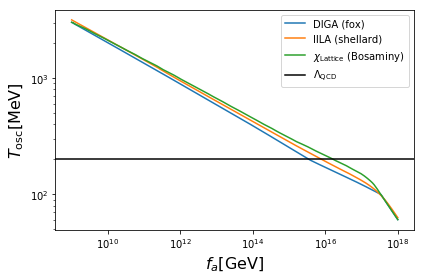

In [110]:
plot_T_osc(axion_mass.m_a_fox, "DIGA (fox)")
plot_T_osc(axion_mass.m_a_shellard, "IILA (shellard)")
plot_T_osc(axion_mass.m_a_from_chi_general, r"$\chi_\mathrm{Lattice}$ (Bosaminy)")
plt.axhline(model.Lambda_QCD / 1e6, color="black", label=r"$\Lambda_\mathrm{QCD}$")
# plt.axhline(model.Lambda_QCD * c.elementary_charge / c.Boltzmann, color="black", label=r"$\Lambda_\mathrm{QCD}$")
plt.legend()
plt.tight_layout()

## Solve EOM

### As a function of T

In [144]:
debug = True

def axion_eom_T_rhs(T, y, f_a, m_a_fn, g_model):
    """
    Computes the rhs of the eom of the axion field as a function of the temperature,
    given the temperature in eV, y = [theta(T), dtheta/dT(T)], g_model is a GStarModel,
    m_a_fn : T x f_a -> m_a [eV]
    """
    theta, dthetadT = y
    H = hubble_parameter_in_rad_epoch(T, g_model)
    dtdT = time_temp.dtdT(T, g_model)
    d2tdT2 = time_temp.d2tdT2(T, g_model)
    d2thetadT2 = - (3 * H * dtdT - d2tdT2 / dtdT) * dthetadT - m_a_fn(T, f_a)**2 * dtdT**2 * np.sin(theta)
    if debug:
        print("----------------------------------")
        print("T =", T / 1e6, "MeV")
        print("theta =", theta)
        print("d2thetadT2 =", d2thetadT2)
        print("H =",H)
        print("dtdT =",dtdT)
        print("d2tdT2 =", d2tdT2)
        print("m_a**2 =", m_a_fn(T, f_a), "** 2 =", m_a_fn(T, f_a)**2)
    return dthetadT, d2thetadT2

In [145]:
def sim_axion_field_evo_T(theta_i, f_a, m_a_fn, g_model, from_T_osc=5, to_T_osc=1):
    """
    Solve the EOM for the axion field. Takes the initial field value theta_i, the axion decay constant f_a,
    the axion mass as a function of temperature m_a_fn : f_a x T -> m_a and the model
    the the eff. rel. dof. : GStarModel.
    Returns the temperature and the field values
    """
    T_osc = find_T_osc(f_a, m_a_fn, g_model)
    T_range = (from_T_osc * T_osc, to_T_osc * T_osc)
    sol = inte.solve_ivp(lambda T, y: axion_eom_T_rhs(T, y, f_a, m_a_fn, g_model), T_range, (theta_i, 0))
    return sol.t, sol.y[0, :]

----------------------------------
T = 2107.8019254987607 MeV
theta = 1e-05
d2thetadT2 = -9.49764719447e-33
H = 5.39163240164e-09
dtdT = -0.0178958766633
d2tdT2 = 2.60326033673e-11
m_a**2 = 1.7220868026777825e-12 ** 2 = 2.96558295596e-24
----------------------------------
T = 2107.8019255 MeV
theta = 1e-05
d2thetadT2 = -9.49764719447e-33
H = 5.39163240164e-09
dtdT = -0.0178958766633
d2tdT2 = 2.60326033673e-11
m_a**2 = 1.7220868026777825e-12 ** 2 = 2.96558295596e-24
----------------------------------
T = 2107.8019255 MeV
theta = 1e-05
d2thetadT2 = -9.49764719447e-33
H = 5.39163240164e-09
dtdT = -0.0178958766633
d2tdT2 = 2.60326033673e-11
m_a**2 = 1.7220868026777825e-12 ** 2 = 2.96558295596e-24
----------------------------------
T = 2107.8019255 MeV
theta = 1e-05
d2thetadT2 = -9.49764719447e-33
H = 5.39163240164e-09
dtdT = -0.0178958766633
d2tdT2 = 2.60326033673e-11
m_a**2 = 1.7220868026777825e-12 ** 2 = 2.96558295596e-24
----------------------------------
T = 2107.8019255 MeV
theta = 1e

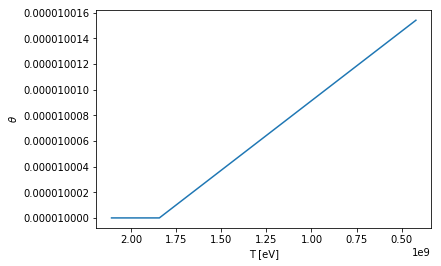

In [147]:
T, phi = sim_axion_field_evo_T(1e-5, 1e14 * 1e9, axion_mass.m_a_shellard, g_star.borsamyi_table)
plt.plot(T, phi)
plt.xlabel("T [eV]")
plt.ylabel(r"$\theta$")
plt.gca().invert_xaxis()